In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import nn, optim
from torch.utils import data
import torchvision
from torchvision import datasets, transforms

from livelossplot import PlotLosses

In [2]:
torch.manual_seed(42)

In [3]:
classes = ["apple", "spider", "octopus", "snowflake"]

In [4]:
limit=500

In [5]:
images = []

for label in classes:
    X = np.load('google_draw/{}.npy'.format(label))
    print("Loaded  {} out of {} {}s".format(limit, X.shape[0], label))
    images.append(X[:limit])

X = np.concatenate(images)
Y = np.concatenate([limit * [i] for i in range(len(classes))])

Loaded  500 out of 144722 apples
Loaded  500 out of 209447 spiders
Loaded  500 out of 150152 octopuss
Loaded  500 out of 116685 snowflakes


In [6]:
print("X shape: {}, type:{}".format(X.shape,X.dtype))

X shape: (2000, 784), type:uint8


In [7]:
X = X.reshape(-1, 1, 28, 28)
X = X.astype('float32') / 255.
X = np.pad(X, [(0, 0), (0, 0), (2, 2), (2, 2)], mode='constant')

# (samples, channels, x, y)
X.shape

(2000, 1, 32, 32)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [9]:
# define data loaders
dataloaders = {
    'train':
    data.DataLoader(
        data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train).long()),
        batch_size=64,
        shuffle=True, num_workers=4
    ),
    'validation': 
    data.DataLoader(
        data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test).long()),
        batch_size=64,
        shuffle=False, num_workers=4
    )
}

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')


In [11]:
device.type

'cuda'

In [12]:
def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels.data).sum().item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
        
        liveloss.update(logs)
        liveloss.draw()
    return model

In [13]:
# antipattern in PyTorch, don't do it!
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [19]:
class PrimeNet(nn.Module):
    def __init__(self, activation_fun, reduction_fun, conv_block_count,conv_count,linear_count=1):
        
        #when 32x32 there can be conv_block in [0,4]
        super().__init__()
        init_size=32
        self.activation_fun=activation_fun
        self.reduction_fun=reduction_fun
        self.conv_block=[]
        self.conv=[]
        self.linear=[]
        ch_in=1
        #hear it can be another initial ch_out
        ch_out=init_size/2
        for i in range(conv_block_count): 
            print("output size conv_block: {}".format(ch_out))
            self.conv_block.append(self._conv_block(int(ch_in),int(ch_out)))
            ch_in=ch_out
            ch_out*=2
        ch_out/=2
        print("output size beetween: {}".format(ch_out))
        for i in range(conv_count):
            print("output size conv: {}".format(ch_out))
            self.conv.append(self._conv(int(ch_in),int(ch_out)))
            ch_in=ch_out
            #ch_out=
        ch_in=int(ch_out*((init_size/(2**conv_block_count))**2))
        ch_out=128
        print("linear input size: {}".format(ch_in))
        self.linear_first=self._linear_first(int(ch_in),int(ch_out))
        ch_in=ch_out
        ch_out=64
        for i in range(linear_count):
            print("output size linear: {}".format(ch_out))
            self.linear.append(self._linear(int(ch_in),int(ch_out)))
            ch_in=ch_out
            #ch_out=
        self.fc = nn.Sequential(
            nn.Linear(ch_out, len(classes))
        )
    
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            self.activation_fun(inplace=True),
            self.reduction_fun(2, 2)
        )
    def _conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            self.activation_fun(inplace=True)
        )
    def _linear_first(self, in_channels, out_channels):
        return nn.Sequential(
            Flatten(),
            nn.Linear(in_channels, out_channels),
            self.activation_fun(inplace=True),
            nn.Dropout(0.5)
        )
    def _linear(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Linear(in_channels, out_channels),
            self.activation_fun(inplace=True),
            nn.Dropout(0.5)
        )
    def forward(self, x):
        for conv_block in self.conv_block:
            x=conv_block(x)
        for conv in self.conv:
            x=conv(x)
        x=self.linear_first(x)
        for linear in self.linear:
            x=linear(x)
        x = self.fc(x)
        return x

In [20]:
model1=PrimeNet(nn.ReLU, nn.MaxPool2d,1,2,1 )
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
epoch_num=20

output size conv_block: 16.0
output size beetween: 16.0
output size conv: 16.0
output size conv: 16.0
linear input size: 4096
output size linear: 64


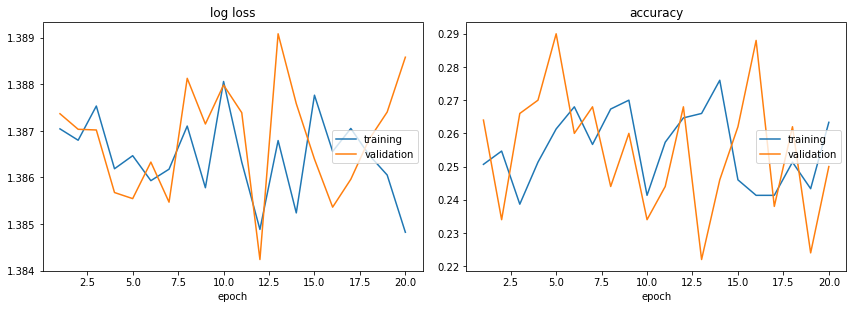

log loss:
training   (min:    1.385, max:    1.388, cur:    1.385)
validation (min:    1.384, max:    1.389, cur:    1.389)

accuracy:
training   (min:    0.239, max:    0.276, cur:    0.263)
validation (min:    0.222, max:    0.290, cur:    0.250)


In [24]:
model1_trained = train_model(model1, criterion, optimizer1, num_epochs=epoch_num)
#0.6

In [25]:
model1=PrimeNet(nn.ReLU, nn.MaxPool2d,1,2,5 )
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
epoch_num=20

output size conv_block: 16.0
output size beetween: 16.0
output size conv: 16.0
output size conv: 16.0
linear input size: 4096
output size linear: 64
output size linear: 64
output size linear: 64
output size linear: 64
output size linear: 64


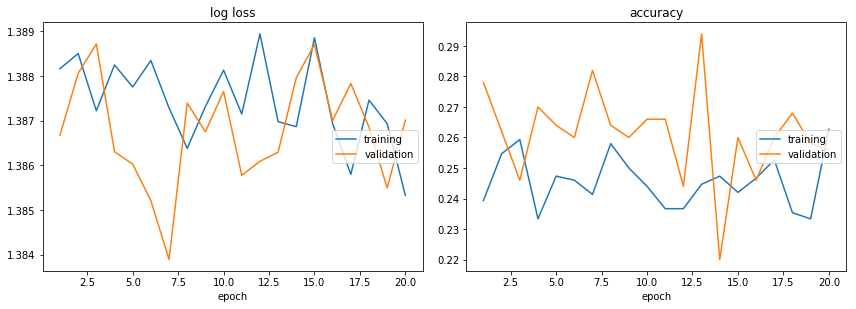

log loss:
training   (min:    1.385, max:    1.389, cur:    1.385)
validation (min:    1.384, max:    1.389, cur:    1.387)

accuracy:
training   (min:    0.233, max:    0.263, cur:    0.263)
validation (min:    0.220, max:    0.294, cur:    0.256)


In [23]:
model1_trained = train_model(model1, criterion, optimizer1, num_epochs=epoch_num)

In [26]:
def make_connector_2conv(in_channels, out_channels, intermediate_channels=None):
    if not intermediate_channels:
        intermediate_channels = in_channels
    
    return nn.Sequential(
        nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, padding=0),
        nn.ReLU(inplace=True),
        nn.Conv2d(intermediate_channels, out_channels, kernel_size=1, padding=0),
        nn.ReLU(inplace=True)
    )

In [27]:
def make_connector_1conv(in_channels, out_channels, intermediate_channels=None):
    if not intermediate_channels:
        intermediate_channels = in_channels
    
    return nn.Sequential(
        nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, padding=0),
        nn.ReLU(inplace=True)
    )

In [ ]:
def make_connector_(in_channels, out_channels, intermediate_channels=None):
    if not intermediate_channels:
        intermediate_channels = in_channels
    
    return nn.Sequential(
        nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, padding=0),
        nn.ReLU(inplace=True)
    )